In [2]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import math

In [27]:
#print("두 서명인의 이름을 영어로 입력해 주십시오 (※반드시 디렉토리 내 서명이미지 묶음 순서대로)")
#name1, name2 = '', ''
#name1 = input('name1: ')
#name2 = input('name2: ')
name1 = 'kim'
name2 = 'lee'
#print("파일디렉토리를 입력해주세요")
directory = './Group C DB/Level 1/'
file_list = os.listdir(directory)
file_count = len(file_list)
col = 5
row = file_count/col + 1
print("[{}] Total {} Files ({} cols x {} rows)".format(directory, file_count, col, row))

img = []
image = []
cimage = []
timage = []

[./Group C DB/Level 1/] Total 25 Files (5 cols x 6.0 rows)


# Show Original Images

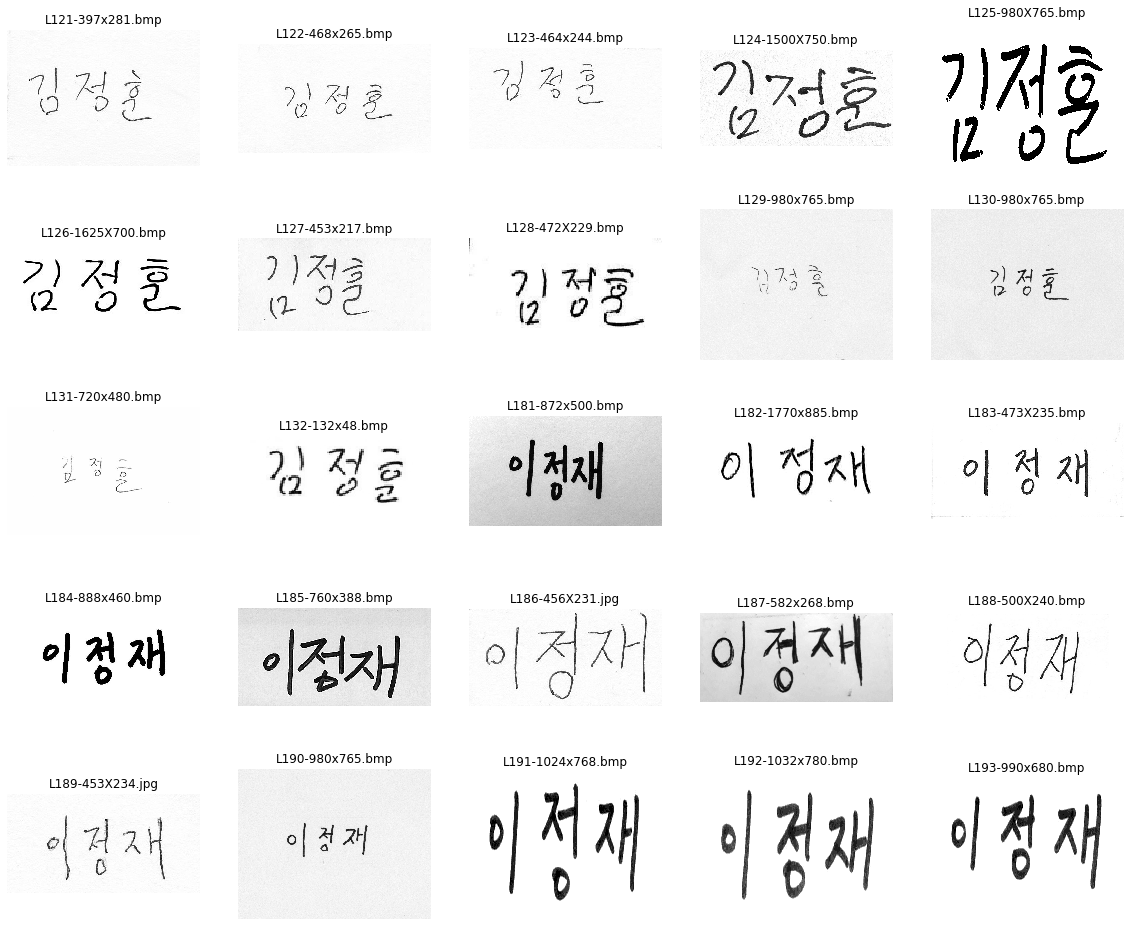

In [28]:
### WARNING !!! LEVEL 2 폴더 L246 번 파일명 잘못 지정되어있어서 불러와지지 않음 - 고친 후 가능
fig = plt.figure(figsize=(20,20))
i = 1

for file in file_list:
    if file.find('.bmp') or file.find('.jpg') != -1:
        #print(directory+file)
        img.append(cv2.imread(directory+file, 0))
        ax = fig.add_subplot(row, col, i)
        ax.imshow(img[i-1],'gray')
        ax.set_title(file)
        ax.axis("off")
        i+=1
plt.show()


# Image Pre-processing (preview)
... to see how this process works

#### 1. Applying Gaussian Blurring and Otsu Thresholding for Binarization

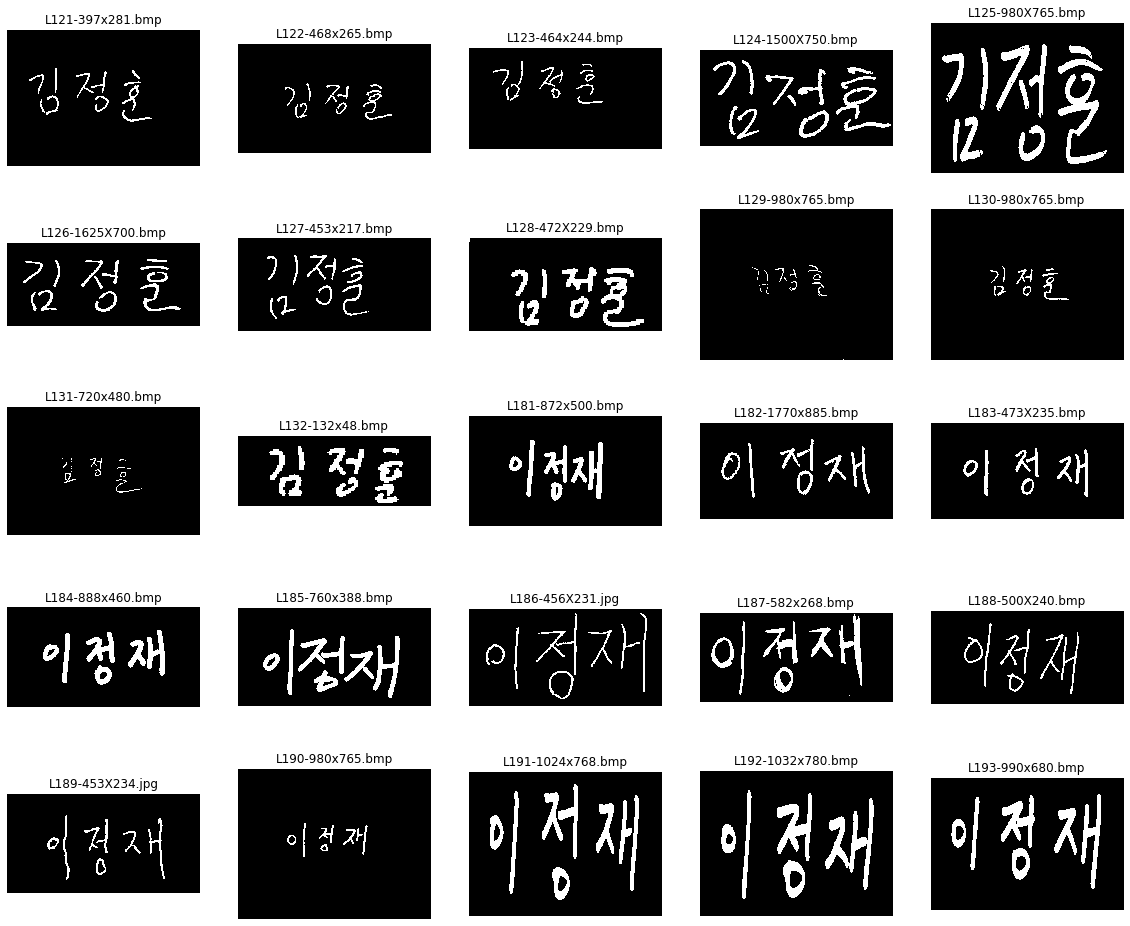

In [29]:
fig = plt.figure(figsize=(20,20))
i = 1
for file in file_list:
    if file.find('.bmp') or file.find('.jpg') != -1:
        
        # Binarization
        blur = cv2.GaussianBlur(img[i-1],(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image.append(np.invert(th3))
        
        ax = fig.add_subplot(row, col, i)
        ax.imshow(image[i-1],'gray')
        ax.set_title(file)
        ax.axis("off")
        i+=1
plt.show()

#### 2. Cropping image to get bounding box

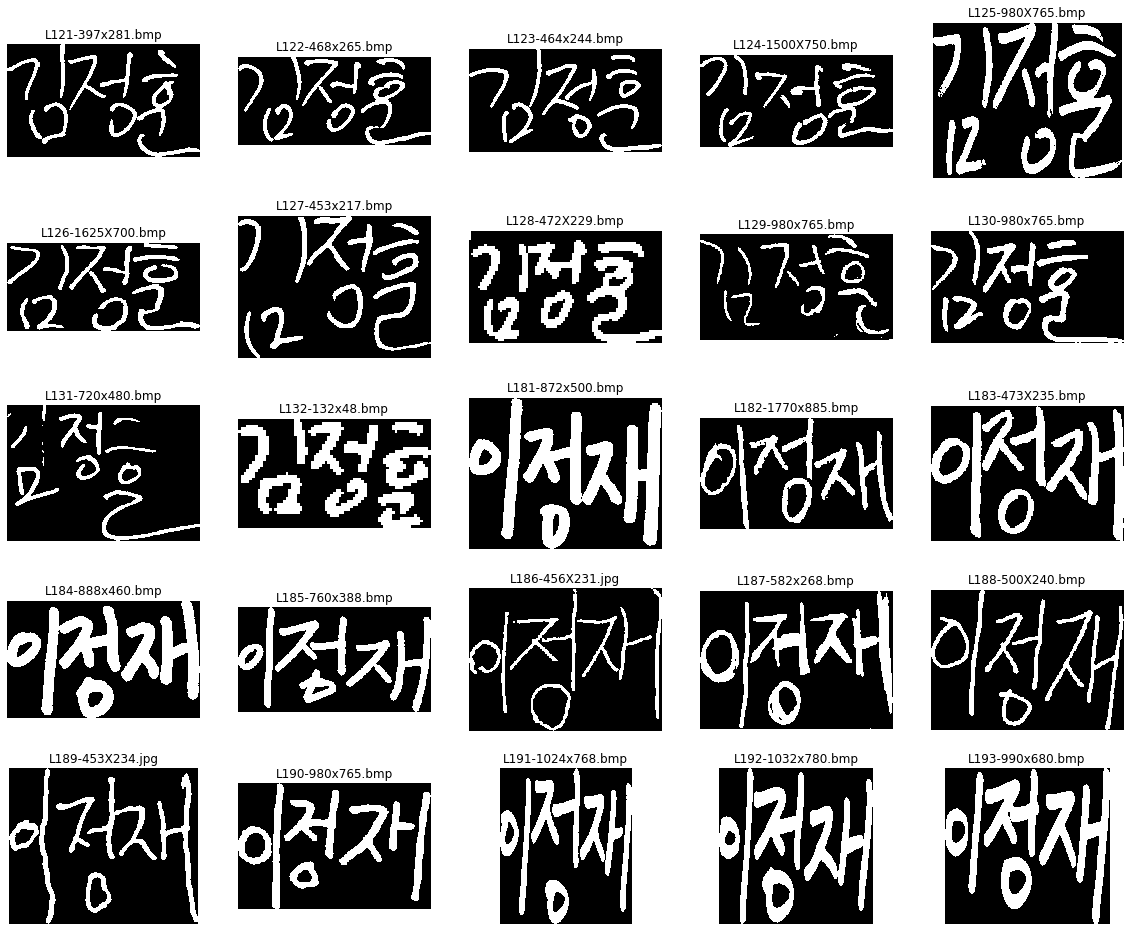

In [30]:
def crop_image(img,tol=0):
    # img is image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

fig = plt.figure(figsize=(20,20))
i = 1
for file in file_list:
    if file.find('.bmp') or file.find('.jpg') != -1:
        
        # Crop
        cimage.append(crop_image(image[i-1], tol=0))
        
        ax = fig.add_subplot(row, col, i)
        ax.imshow(cimage[i-1],'gray')
        ax.set_title(file)
        ax.axis("off")
        i+=1
plt.show()

#### 3. Thinning the image

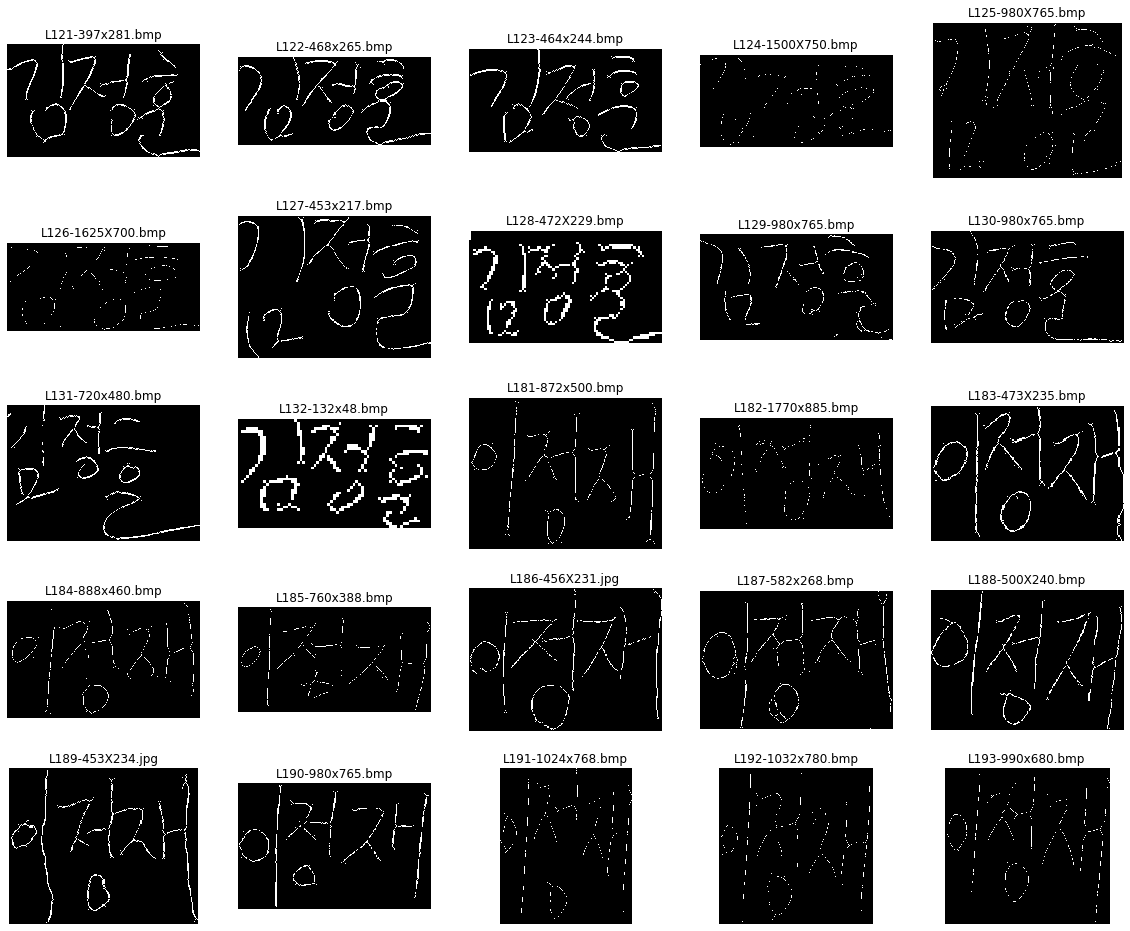

In [31]:
def thinning(img):
    #img = cimg
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel

fig = plt.figure(figsize=(20,20))
i = 1
for file in file_list:
    if file.find('.bmp') or file.find('.jpg') != -1:
        
        # Thinning
        timage.append(thinning(cimage[i-1]))
        
        ax = fig.add_subplot(row, col, i)
        ax.imshow(timage[i-1],'gray')
        ax.set_title(file)
        ax.axis("off")
        i+=1
plt.show()

#### Dividing image into 4 parts (top_left, top_right, bottom_left, bottom_right)

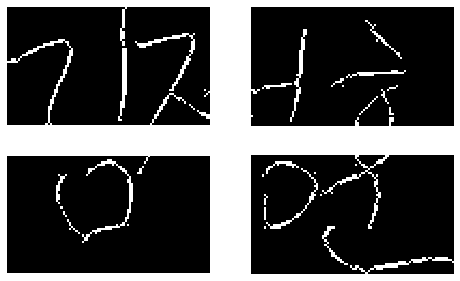

In [32]:
# For Forgery distinguishment
# finding number of white pixels and connected components in signagure
"""
area = cv2.countNonZero(timage[0])
print("Number of white pixels(area):", area)
img1 = np.invert(timage[0])
cc = cv2.connectedComponents(img1)[0]
print("Connected Components:", cc)
"""

timg = timage[0]
rows,cols=timg.shape
img_tl=timg[0:int(rows/2),0:int(cols/2)]
img_tr=timg[int(rows/2)+1:rows,0:int(cols/2)]
img_bl=timg[0:int(rows/2),int(cols/2)+1:cols]
img_br=timg[int(rows/2)+1:rows,int(cols/2)+1:cols]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(img_tl,'gray')
ax.axis("off")
ax = fig.add_subplot(2, 2, 3)
ax.imshow(img_tr,'gray')
ax.axis("off")
ax = fig.add_subplot(2, 2, 2)
ax.imshow(img_bl,'gray')
ax.axis("off")
ax = fig.add_subplot(2, 2, 4)
ax.imshow(img_br,'gray')
ax.axis("off")
plt.show()

#### Finding Centre of gravity of each sub-image

In [33]:
# Find Centre of gravity of each sub-image
def COG(img):
    x_cor=0
    xrun_sum=0
    y_cor=0
    yrun_sum=0
    #print(img.shape)
    for i in range(img.shape[0]):
        x_cor+=sum(img[i])*i/255
        xrun_sum+=sum(img[i])/255

    for i in range(img.shape[1]):
        y_cor+=sum(img[:,i])*i/255
        yrun_sum+=sum(img[:,i])/255
        #print(img.shape[1]) 
        if yrun_sum==0:
            x_pos=0
        else:
            x_pos=y_cor/(yrun_sum)
        if xrun_sum==0:
            y_pos=0
        else:
            y_pos=x_cor/(xrun_sum)
    
    return (x_pos/img.shape[1],y_pos/img.shape[0])

def coords(timg):
    rows,cols=timg.shape
    img_tl = timg[0:int(rows/2),0:int(cols/2)]
    img_tr = timg[int(rows/2)+1:rows,0:int(cols/2)]
    img_bl = timg[0:int(rows/2),int(cols/2)+1:cols]
    img_br = timg[int(rows/2)+1:rows,int(cols/2)+1:cols]
    
    tl_x,tl_y=COG(img_tl)
    tr_x,tr_y=COG(img_tr)
    bl_x,bl_y=COG(img_bl)
    br_x,br_y=COG(img_br)

    return tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y

... then let's do image pre- processing for all of the signatures and
# Generating Feature Dataset of Images 

In [34]:
data=[]

i = 1
for file in file_list:
    if file.find('.bmp') or file.find('.jpg') != -1:
        
        # binarization
        img = cv2.imread(directory+file,0)
        blur = cv2.GaussianBlur(img,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image=np.invert(th3)
        
        #crop
        cimg=crop_image(image,tol=0)
        # area=cv2.countNonZero(cimg)/(cimg.shape[0]*cimg.shape[1])
        
        #Thinning the image
        timg=thinning(cimg)
        
        """
        #Find proportion of white cells
        img1=np.invert(cimg)
        #Generate connected components
        cc=cv2.connectedComponents(img1)[0]
        area=cv2.countNonZero(timg)/(timg.shape[0]*timg.shape[1])
        """
        
        # Divide into 4 parts and get coordiate of each COG (Extracting features)
        tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y=coords(timg)
        
        ### put area and cc if you want
        x=pd.Series([file,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y],index=
                    ["File","tl_x","tl_y","tr_x","tr_y","bl_x","bl_y","br_x","br_y"])
        data.append(x)
        i+=1

df=pd.DataFrame(data)

# For Forgery distinguishment
# if we want to label images at pre-processing
""" 
df['name'] = np.nan
for i in range (len(file_list)):
    if i < 11: df.loc[i,['name']] = name1
    else: df.loc[i,['name']] = name2
    i+=1
"""

" \ndf['name'] = np.nan\nfor i in range (len(file_list)):\n    if i < 11: df.loc[i,['name']] = name1\n    else: df.loc[i,['name']] = name2\n    i+=1\n"

In [35]:
df.head()
#df # print all

,File,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y
0,L121-397x281.bmp,0.565399,0.520333,0.468384,0.347997,0.424293,0.572816,0.470073,0.495879
1,L122-468x265.bmp,0.599389,0.480184,0.465375,0.416656,0.438907,0.530944,0.453929,0.511840
2,L123-464x244.bmp,0.542735,0.539859,0.525118,0.360648,0.432292,0.544648,0.476756,0.498136
3,L124-1500X750.bmp,0.476090,0.483705,0.473150,0.542479,0.475593,0.597720,0.443795,0.471088
4,L125-980X765.bmp,0.545577,0.525698,0.448222,0.536954,0.456920,0.517417,0.471154,0.487526


In [36]:
df.describe()

,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.527517,0.571326,0.516497,0.437894,0.468176,0.570949,0.518896,0.408532
std,0.040447,0.085035,0.075552,0.087419,0.073004,0.054172,0.077853,0.108126
min,0.474892,0.360240,0.381962,0.199593,0.260892,0.459210,0.351272,0.278345
25%,0.492047,0.516196,0.468384,0.397019,0.438907,0.530944,0.470073,0.312299
50%,0.531102,0.587608,0.525118,0.438337,0.488496,0.581424,0.500726,0.353034
75%,0.549260,0.641149,0.565772,0.500426,0.508233,0.603440,0.593221,0.495879
max,0.624180,0.705264,0.692821,0.576076,0.607651,0.679574,0.639086,0.604432


# Verifying which signature belongs to whom

#### Comparing each 8 coordinates with name1 avg. or name2 avg. 

[1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1]
[1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
[1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1]
[-1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


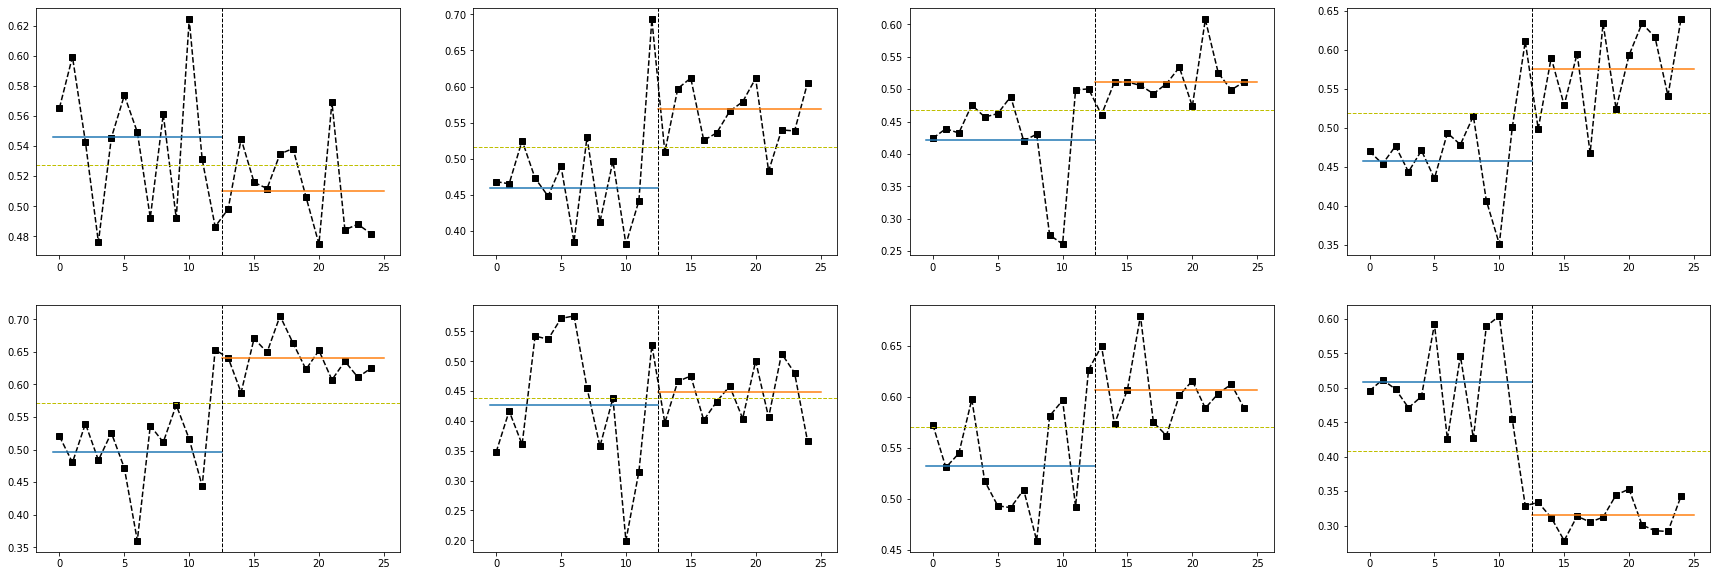

In [37]:
xtl = df["tl_x"]
ytl = df["tl_y"]
xtr = df["tr_x"]
ytr = df["tr_y"]
xbl = df["bl_x"]
ybl = df["bl_y"]
xbr = df["br_x"]
ybr = df["br_y"]

# find out whether corresponding coordinate belongs to name1 or name2
# name1: return 1, name2: return -1
def whether (coor):
    result = []
    for i in coor:
        if abs(i-coor[0:file_count//2].mean()) < abs(i-coor[file_count//2:].mean()): result.append(1)
        else: result.append(-1)
    return result

# plot graph of coordinates of each images and return the list of results
def plot_coor(coor):
    plt.plot(coor, 'ks--')
    plt.axhline(y=coor.mean(), color='y', linestyle='--', linewidth=1) #horizontal line; overall avg.
    plt.plot([-0.5,file_count/2],[coor[0:file_count//2].mean(), coor[0:file_count//2].mean()]) #name1 avg.
    plt.plot([file_count/2, file_count],[coor[file_count//2:].mean(), coor[file_count//2:].mean()]) #name2 avg.
    plt.axvline(x=file_count/2, color='k', linestyle='--', linewidth=1) #vertical; divide name1&name2 (imperfect)
    #plt.grid(True)
    #plt.show()
    coor_result = whether(coor)
    print(coor_result)
    return coor_result

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(2, 4, 1)
xtl_result = plot_coor(xtl)
ax = fig.add_subplot(2, 4, 2)
xtr_result = plot_coor(xtr)
ax = fig.add_subplot(2, 4, 3)
xbl_result = plot_coor(xbl)
ax = fig.add_subplot(2, 4, 4)
xbr_result = plot_coor(xbr)
ax = fig.add_subplot(2, 4, 5)
ytl_result = plot_coor(ytl)
ax = fig.add_subplot(2, 4, 6)
ytr_result = plot_coor(ytr)
ax = fig.add_subplot(2, 4, 7)
ybl_result = plot_coor(ybl)
ax = fig.add_subplot(2, 4, 8)
ybr_result = plot_coor(ybr)

plt.show()



#### Generalize all of the results and decide who's signature is

In [38]:
final_result = [] # total result(avg. of results) of each images 
i = 0
for file in file_list:
    coor_sum = xtl_result[i] + xtr_result[i] + xbl_result[i] + xbr_result[i] \
             + ytl_result[i] + ytr_result[i] + ybl_result[i] + ybr_result[i]
    
    # if total result(avg. of results) is >0, it's name1
    # else: name2
    if coor_sum/8 > 0: final_result.append(name1)
    else: final_result.append(name2)
    
    print("{:<20} >>  {} : {}".format(file, final_result[i], coor_sum/8))
    i+=1


L121-397x281.bmp     >>  kim : 0.75
L122-468x265.bmp     >>  kim : 1.0
L123-464x244.bmp     >>  kim : 0.75
L124-1500X750.bmp    >>  lee : 0.0
L125-980X765.bmp     >>  kim : 0.75
L126-1625X700.bmp    >>  kim : 0.75
L127-453x217.bmp     >>  kim : 0.5
L128-472X229.bmp     >>  kim : 0.25
L129-980x765.bmp     >>  kim : 1.0
L130-980x765.bmp     >>  kim : 0.25
L131-720x480.bmp     >>  kim : 0.75
L132-132x48.bmp      >>  kim : 0.75
L181-872x500.bmp     >>  lee : -1.0
L182-1770x885.bmp    >>  lee : 0.0
L183-473X235.bmp     >>  lee : -0.75
L184-888x460.bmp     >>  lee : -1.0
L185-760x388.bmp     >>  lee : -0.75
L186-456X231.jpg     >>  lee : -0.25
L187-582x268.bmp     >>  lee : -0.5
L188-500X240.bmp     >>  lee : -0.75
L189-453X234.jpg     >>  lee : -1.0
L190-980x765.bmp     >>  lee : -0.25
L191-1024x768.bmp    >>  lee : -1.0
L192-1032x780.bmp    >>  lee : -1.0
L193-990x680.bmp     >>  lee : -0.75


# Let's see whether algorithm worked fine !
<WARNING!> redo [Show Original Images] cell and then execute below sell

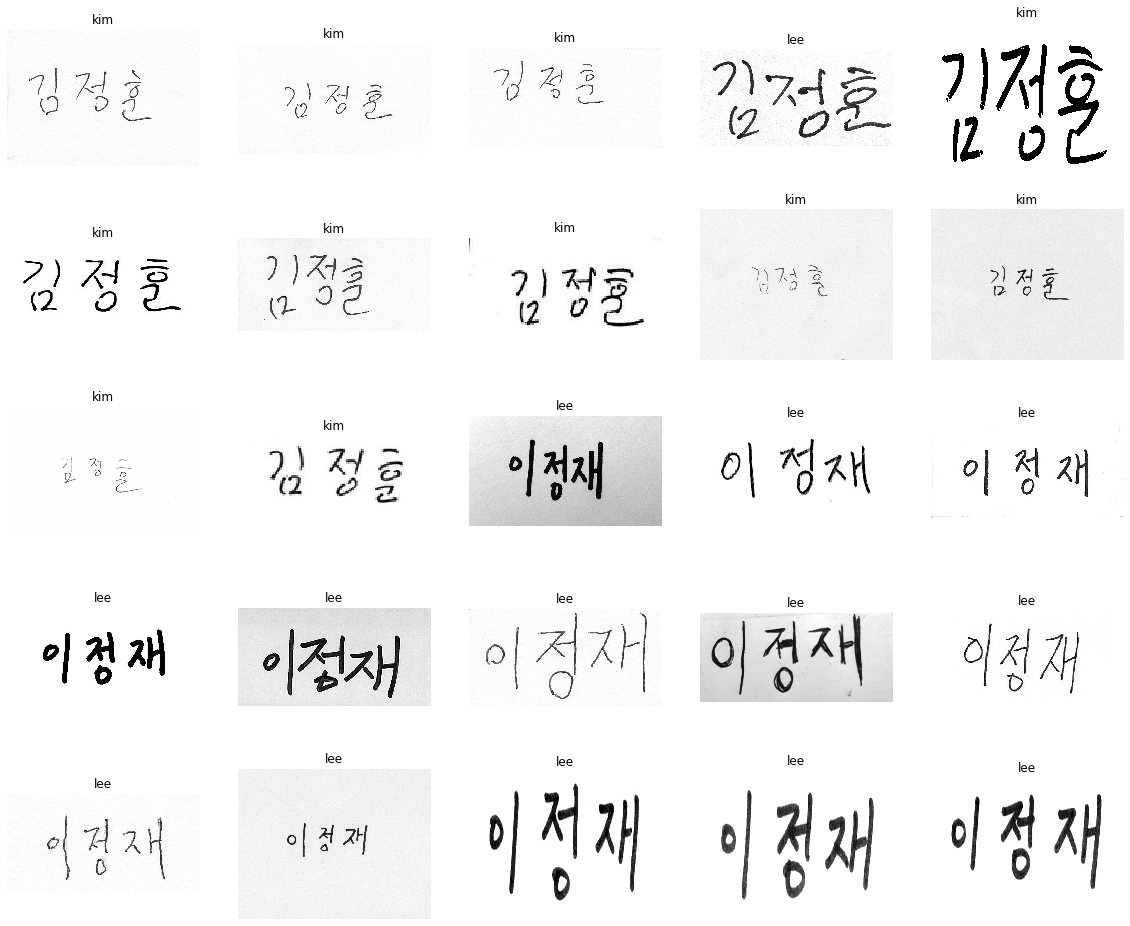

In [44]:
fig = plt.figure(figsize=(20,20))
i = 1
for file in file_list:
    if file.find('.bmp') or file.find('.jpg') != -1:
        ax = fig.add_subplot(row, col, i)
        ax.imshow(img[i-1],'gray')
        ax.set_title(final_result[i-1])
        ax.axis("off")
        i+=1
plt.show()


A Mean:  0.49659094827633443 
B Mean:  0.4860823563592118
 >>> B !!

- Between A Mean & A: 
0    -0.0833256422
1    -0.0170331161
2    -0.0179572958
3     0.0574739756
4     0.0351005872
5     0.0088465077
6    -0.0163961098
7     0.0129107180
8     0.0819413427
9    -0.0027836506
10   -0.0587773168
Name: tl_x, dtype: float64
-0.00000000000000004037

- Between A Mean & B: 
0    -0.0728170502
1    -0.0065245242
2    -0.0074487039
3     0.0679825675
4     0.0456091791
5     0.0193550997
6    -0.0058875178
7     0.0234193099
8     0.0924499346
9     0.0077249413
10   -0.0482687249
Name: tl_x, dtype: float64
0.01050859191712257175

- Between B Mean & A: 
11    0.0136261095
12   -0.0291186360
13   -0.0513158954
14   -0.0406754553
15   -0.0102152869
16   -0.0128068958
17    0.0715926470
18    0.0291797994
19    0.0097050371
20   -0.0817111562
21   -0.0070029174
22   -0.0173604531
Name: tl_x, dtype: float64
-0.01050859191712257522

- Between B Mean & B: 
11    0.0241347014
12   -0.0186100441


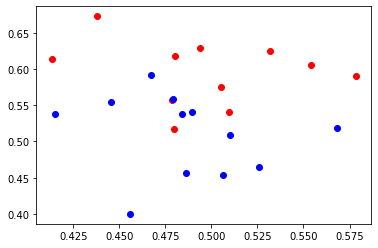

In [549]:
# It's also to find out whether the signature is forged or not w/ labelling
# ... need to be modified, and not completely coded
"""
groups = df.groupby('name')

# b,g,r,c,y,m,k,w
# tl
fig, ax = plt.subplots()
#fig, bx = plt.subplots()
#fig, cx = plt.subplots()
#fig, dx = plt.subplots()

tlx_Amean = 0
tlx_Bmean = 0
A = []
B = []
for name, group in groups:
    if name == 'A':
        tlx_Amean = group.tl_x.mean()
        A = group.tl_x
        ax.plot(group.tl_x, group.tl_y, marker='o', color = 'r', linestyle='', label=name)
        #bx.plot(group.tr_x, group.tr_y, marker='o', color = 'r', linestyle='', label=name)
        #cx.plot(group.bl_x, group.bl_y, marker='s', color = 'm', linestyle='', label=name)
        #dx.plot(group.br_x, group.br_y, marker='s', color = 'm', linestyle='', label=name)
    else:
        tlx_Bmean = group.tl_x.mean()
        B = group.tl_x
        ax.plot(group.tl_x, group.tl_y, marker='o', color = 'b', linestyle='', label=name)
        #bx.plot(group.tr_x, group.tr_y, marker='o', color = 'b', linestyle='', label=name)
        #cx.plot(group.bl_x, group.bl_y, marker='s', color = 'c', linestyle='', label=name)
        #dx.plot(group.br_x, group.br_y, marker='s', color = 'c', linestyle='', label=name)

print("A Mean: ",tlx_Amean, "\nB Mean: ", tlx_Bmean)
A_A = A-tlx_Amean
A_B = A-tlx_Bmean
B_A = B-tlx_Amean
B_B = B-tlx_Bmean
if abs(A_A.mean()) < abs(B_B.mean()): print(" >>> A !!")
else: print(" >>> B !!")
print("\n- Between A Mean & A: \n{}".format(A_A))
print("{:.20f}".format(A_A.mean()))
print("\n- Between A Mean & B: \n{}".format(A_B))
print("{:.20f}".format(A_B.mean()))
print("\n- Between B Mean & A: \n{}".format(B_A))
print("{:.20f}".format(B_A.mean()))
print("\n- Between B Mean & B: \n{}".format(B_B))
print("{:.20f}".format(B_B.mean()))
#ax.legend(fontsize=12, loc='lower right') # legend position
#plt.title('tl', fontsize=20)
plt.show()
"""